# Chapter03 분류

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

MNIST 데이터셋

In [2]:
# MNIST 데이터셋을 내려받는 코드

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)  # 784=28*28, 이미지
print(y.shape)  # 타깃값

(70000, 784)
(70000,)


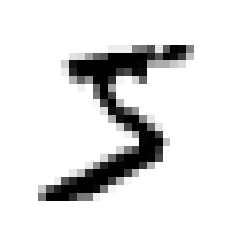

In [4]:
some_digit = X[0]   # 첫 번째 샘플
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0]   # 첫 번째 샘플의 타깃값

'5'

In [6]:
y = y.astype(np.uint8)  # y를 정수로 변환

In [7]:
# (잘 섞여진 데이터) 훈련세트, 테스트세트로 나누기
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### 3.2 이진 분류기 훈련

단순화해서 5인지 아닌지를 구분하는 '5-감지기'를 만들어보자

In [8]:
# 5이면 True, 아니면 False
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
# 확률적경사하강법 (SGD) 분류기로 훈련
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])   # 훈련한 SGD모델로 첫 번째 샘플 예측

# True (5가 맞음)으로 예측

array([ True])

### 3.3 성능 측정

교차검증으로 정확도 측정

In [11]:
# 교차 검증 구현  (cross_val_score()함수와 거의 같음)
from sklearn.model_selection import StratifiedKFold    # 계층적 샘플링이 적용된 K-폴드
from sklearn.base import clone#  동일한 모수를 사용하여 새로운 적합하지 않은 추정량을 생성함

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# X_train을 y_train_5 의 클래스별 비율이 유지되도록 폴드를 만듦
for train_index, test_index in skfolds.split(X_train, y_train_5):  # train_index: 훈련세트
    clone_clf = clone(sgd_clf)                                     # test_index:  검증세트
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)  # 훈련세트에서 훈련
    y_pred = clone_clf.predict(X_test_fold)      # 검증세트에서 예측
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기

# 사이킷런의 BaseEsimators를 활용하면 Customized된 Estimator 생성 가능
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)   # 모두 '5가 아니다'라고 예측

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

더미 분류기를 사용했음에도 불구하고 정확도가 높게 나옴 --> 성능 측정 지표로 정확도는 부적절하다!!

---

- 오차 행렬 :
 
 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

![image.jpg](http://jcsites.juniata.edu/faculty/rhodes/ml/images/confmat)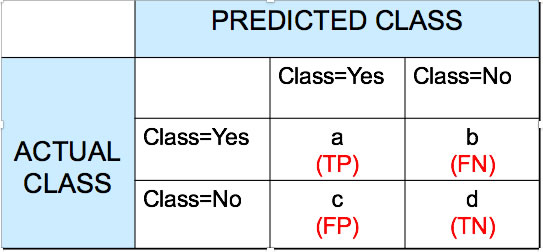

In [15]:
# 실제 타깃값과 비교할 수 있는 예측값 만들기
from sklearn.model_selection import cross_val_predict

# 각 검증 폴드에서 얻은 예측 반환
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
# 오차 행렬 만들기
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 행 : 실제 클래스

- 열 : 예측한 클래스

 첫 번째 : 음성 클래스, 두 번째 : 양성 클래스

정밀도 (precision) = $\frac{TP}{TP + FP}$ : 양성으로 예측한 것중 진짜 양성의 비율

재현율 (recall) = $\frac{TP}{TP + FN}$ : 실제 양성인 것중 제대로 예측한 것의 비율

( $TP$ : 진짜 양성, $TN$ : 진짜 음성, $FP$ : 거짓 양성, $FN$ : 거짓 음성 )

In [17]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))  # 정밀도
print(recall_score(y_train_5, y_train_pred))     # 재현율

0.8370879772350012
0.6511713705958311


- F1 점수 : 정밀도와 재현율의 조화 평균

 $F1 = \frac{2}{\frac{1}{정밀도}+ \frac{1}{재현율}}$

 정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높다.

 하지만 상황에 따라 정밀도와 재현율의 중요도가 다를 수 있다.

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도 / 재현율 트레이드오프

**결정 함수** (decision function) 로 각 샘플의 점수를 계산하여 점수가 임곗값보다 크면 양성클래스로, 작으면 음성클래스에 할당

- 결정 임곗값을 높이면 : 재현율↓ , 정밀도↑

- 결정 임곗값을 내리면 : 재현율↑ , 정밀도↓

In [19]:
y_scores = sgd_clf.decision_function([some_digit])  # 해당 샘플의 결정함수
y_scores

array([2164.22030239])

In [20]:
threshold = 0  # 임곗값 지정
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
threshold = 4000   # 임곗값을 올려보자
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

적절한 임곗값 구하기

In [22]:
# 우선 cross_val_predict()로 훈련 세트에 있는 결정함수를 구한다.
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [23]:
# precision_recall_curve()로 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있다
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds =  precision_recall_curve(y_train_5, y_scores)

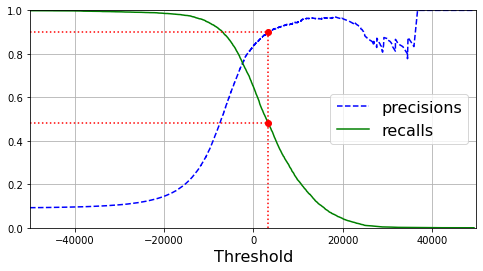

In [24]:
# 임곗값의 함수로 정밀도와 재현율을 그려보자
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precisions')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recalls')
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

# np.argmax() : 최댓값의 첫 번째 인덱스를 반환
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]       # precisions가 0.9 보다 크게 하는 최대한의 recalls로 지정
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # precisions를 0.9 보다 크게 하는 최소한의 임곗값으로 지정

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")       # 빨간 세로줄
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                      # 빨간 가로줄 위에꺼
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:") # 빨간 가로줄 밑에꺼
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")

plt.show()

In [25]:
(y_train_pred == (y_scores > 0)).all()  # all(): 모두 True이면 True, 하나라도 False가 있으면 False

# y_scores가 0보다 크면 모두 5라고 예상

True

정밀도 90%를 달성하는 것이 목표라고 가정해보자.

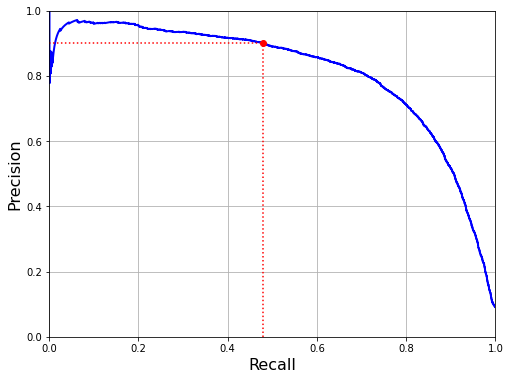

In [26]:
# 재현율에 대한 정밀도 곡선 (PR 곡선)
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")

plt.show()

- 재현율 80% 근처에서 정밀도가 급격히 줄기 시작하는데, 이 하강점 직전을 ' 정밀도 / 재현율 트레이드오프 ' 로 선택하는 것이 좋다.

- 그래프 아래의 면적이 클수록 좋은 그래프이다.

In [27]:
# threshold_90_precision : 정밀도를 0.90 보다 크게 하는 최소한의 임곗값

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
print(f"정밀도: {precision_score(y_train_5, y_train_pred_90)}")  # 정밀도 계산
print(f"재현율: {recall_score(y_train_5, y_train_pred_90)}")     # 재현율 계산

정밀도: 0.9000345901072293
재현율: 0.4799852425751706


정밀도 90%를 달성한 분류기를 만들었다

- 정밀도와 재현율에 대해서 분류기를 만들려면 임곗값을 조정하면 된다!!

---

- 수신기 조작 특성 ( **ROC** ) 곡선 : $\frac{TP \space(재현율)}{FPR}$

 $FPR = \frac{FP}{FP + TN}$ : 실제 음성 중, 양성으로 예측한 비율

 $TPR = \frac{TP}{TP + FN}$ : 실제 양성 중, 음성으로 예측한 비율 (== 재현율)

In [29]:
# 여러 임곗값에서 TPR, FPR을 계산해주는 메서드
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)   # 매개변수에 타깃값, 예측값을 전달

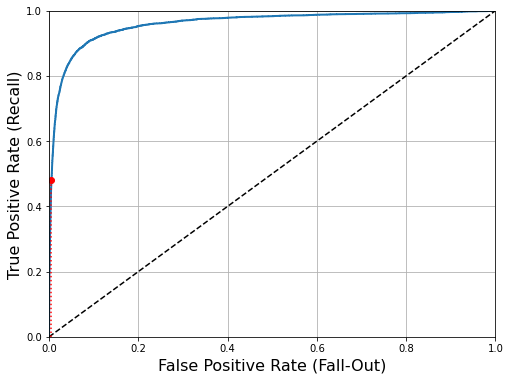

In [30]:
# ROC (TPR에 대한 FPR) 곡선을 그려주는 메서드 정의
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')   # 대각 점선 그리기
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]   # fpr_90 : tpr이 정밀도가 최소 90% 되는 재현율보다 큰거중에 최소의 fpr
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r")
plt.plot([fpr_90], [recall_90_precision], "ro")

plt.show()

# 빨간 점은 최소 90%의 정밀도를 가진 재현율을 뜻함

재현율(TPR)이 높을수록 FPR이 늘어난다.

점선은 완전한 랜덤 분류기 (더미 분류기)의 ROC 곡선을 의미한다.

좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 한다. (왼쪽 위 모서리)

- --> 곡선 아래의 면적 (AUC) : Area Under the Curve 을 측정하면 분류기들을 비교할 수 있다!!
 
 완벽한 분류기는 AUC가 1이고, 완전한 랜덤분류기의 AUC는 0.5이다.


In [31]:
# 사이킷런의 ROC의 AUC를 계산하는 함수
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)  # 매개변수에 타깃값, 예측값을 전달

# 1 에 가까울수록 좋은 분류기이다

0.9604938554008616

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC곡선과 AUC를 비교해보자

In [32]:
# 우선, 훈련 세트에 대한 점수를 얻는다
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
# 각 샘플마다 [음성일 확률, 양성일 확률] 반환

In [33]:
y_probas_forest[35]  # [음성일 확률, 양성일 확률] 반환

array([0.07, 0.93])

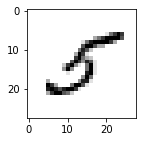

In [34]:
plt.figure(figsize=(2,2))
plt.imshow(X_train[35].reshape(28,28), cmap='gray_r')
plt.show()

In [35]:
y_scores_forest = y_probas_forest[:, 1]  # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

0.9511160302527208 0.4799852425751706 0.005295076861063779


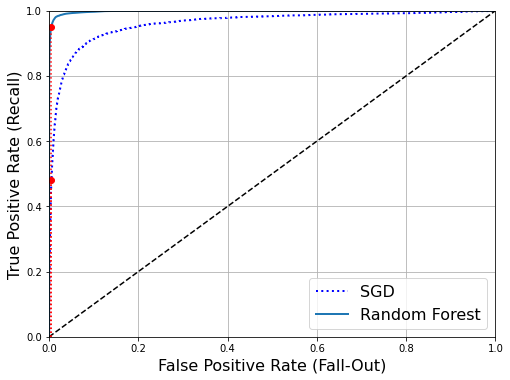

In [36]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]
print(recall_for_forest, recall_90_precision, fpr_90)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

plt.show()

RandomForest분류기가 SGD분류기보다 AUC 값이 크므로 더 좋은 모델이다!

- 임곗값에 따라 빨간점의 위치가 달라지고, 모델의 성능에 따라 ROC곡선의 휨 정도가 달라진다.

In [37]:
print(f"랜덤포레스트 분류기 AUC : {roc_auc_score(y_train_5, y_scores_forest)}")
print(f"SGD 분류기 AUC :\t  {roc_auc_score(y_train_5, y_scores)}")

랜덤포레스트 분류기 AUC : 0.9983436731328145
SGD 분류기 AUC :	  0.9604938554008616


In [38]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print("Random Forest 분류기의 정밀도와 재현율")
print(f"정밀도: {precision_score(y_train_5, y_train_pred_forest)}")
print(f"재현율: {recall_score(y_train_5, y_train_pred_forest)}")

Random Forest 분류기의 정밀도와 재현율
정밀도: 0.9905083315756169
재현율: 0.8662608374838591


### 3.4 다중 분류

SGD, randomforest 등의 분류기는 다중 분류가 가능하지만 로지스틱 회귀나 서포트 벡터 머신 분류기같은 알고리즘은 이진 분류만 가능하다.

- OvR(OvA) : one-versus-the rest, 클래스마다 이진 분류기를 만들어서 가장 높은 결정점수를 낸 클래스를 선택

- OvO : one-versus-one, 모든 가능한 두 개의 클래스 조합 $\frac{n(n-1)}{2}$에 대해 이진 분류기를 만듦. 가장 많이 양성으로  분류된 클래스 선택

다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행한다.

In [83]:
# 훈련 시간이 많이 걸려 1000개의 데이터만 해보자
X_train = X_train[:1000]
y_train = y_train[:1000]
X_test = X_test[:1000]
y_test = y_test[:1000]

In [40]:
# 서포트 벡터 머신 분류기 테스트
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])   # 첫 번째 샘플 예측

array([5], dtype=uint8)

사이킷런 내부에서 OvO로, 45개의 이진분류기를 훈련 후 각각의 결정점수로 가장 높은 클래스 선택한다.

In [65]:
some_digit_scores = svm_clf.decision_function([some_digit]) # 샘플당 10개의 점수를 반환
print(some_digit_scores)

print(np.argmax(some_digit_scores))
# 5가 가장 높다 --> 5로 예측

[[ 0.74425472  2.744763    6.1874606   8.29544346 -0.3001552   9.30508656
   1.74544703  4.79018461  7.19991924  3.84775475]]
5


In [42]:
print(svm_clf.classes_)   # classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장
svm_clf.classes_[np.argmax(some_digit_scores)]

[0 1 2 3 4 5 6 7 8 9]


5

In [43]:
# 사이킷런에서 OvR을 사용하도록 강제
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())  # SVC 기반으로 OvR 전략을 사용하도록 다중분류기를 만듦
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
len(ovr_clf.estimators_)

10

In [45]:
# 확률적경사하강법 (SGD) 분류기로 훈련
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [46]:
sgd_clf.decision_function([some_digit])  # 클래스마다 부여한 점수 확인

array([[-1319644.0334316 , -1094450.22293128,  -477415.20666682,
          -13106.10131312, -1269452.57717759,    82661.50523942,
         -695502.52263771,  -781968.57959698,  -366826.32000484,
         -461749.07969019]])

In [47]:
# 분류기 평가 (일반적으로 교차검증 사용)
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.83863227, 0.86262747, 0.84993998])

In [66]:
# 성능을 더 높이기 위해 정규화 적용
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.83532934, 0.81681682, 0.82882883])

### 3.5 에러 분석

먼저 오차행렬을 살펴보자

In [49]:
# SGD분류기의 오차행렬
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

# 행이 실제클래스, 열이 예측한 클래스를 의미

array([[461,   0,   2,   2,   2,   7,   3,   0,   2,   0],
       [  0, 535,   5,   2,   1,   5,   0,   1,  13,   1],
       [  4,  11, 408,  12,  16,   4,  10,   7,  16,   0],
       [  2,   4,  19, 404,   0,  33,   2,  11,  13,   5],
       [  2,   2,   7,   2, 485,   0,   6,   3,  10,  18],
       [  6,   6,   3,  19,  10, 348,   9,   1,  20,  12],
       [  4,   4,   9,   0,   6,  10, 464,   0,   4,   0],
       [  3,   3,   3,   5,   8,   0,   0, 494,   1,  33],
       [  0,  15,  14,  16,   2,   8,   9,   5, 383,  10],
       [  6,   4,   4,   6,  20,   3,   0,  23,   7, 422]])

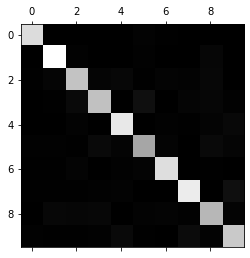

In [50]:
# 오차행렬 그리기
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [51]:
print(conf_mx.shape)
row_sums = conf_mx.sum(axis=1, keepdims=True)   # keepdims=True로 지정하면 차원을 유지시켜줌
print(row_sums.shape)
norm_conf_mx = conf_mx / row_sums   # (에러의 절대 개수가 아니라) 에러비율을 비교하기 위해

(10, 10)
(10, 1)


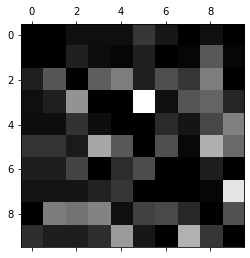

In [52]:
np.fill_diagonal(norm_conf_mx, 0)   # 주대각선만 0으로 채운다
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

위 그림에서 9행 7열이 상당히 밝으므로, 9를 7로 잘못 예측한 데이터가 많다는 것을 의미한다.

- 오차 행렬을 분석하면 분류기의 성능 향상 방안에 대한 통찰을 얻을 수 있다.


In [53]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

In [54]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

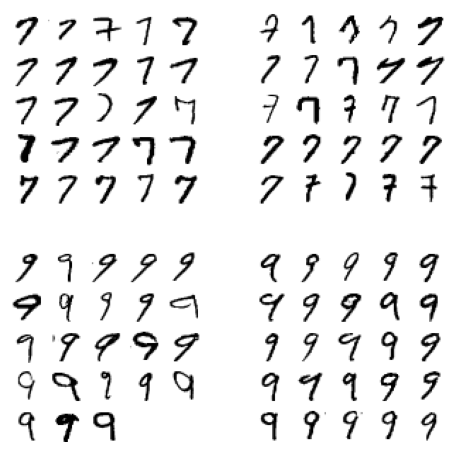

In [55]:
# 7과 9의 샘플 그려보자

cl_a, cl_b = 7, 9
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

9를 7으로 잘못 에측한 데이터가 많다!

- 에러를 줄이는 한가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것이다.

### 3.6 다중 레이블 분류

- 다중 레이블 분류 :

 각 샘플당 레이블이 2개 이상인 분류

In [56]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)    # 7보다 크거나 같으면 True
y_train_odd = (y_train % 2 == 1)  # 홀수면 True
y_multilabel = np.c_[y_train_large, y_train_odd]  # 위 두 레이블을 합친다 (리스트로 묶음)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [57]:
knn_clf.predict([some_digit])

# [7보다 크지않고 (False), 홀수이다 (True)]

array([[False,  True]])

In [58]:
# 다중 레이블 분류기 평가

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')   # 각 레이블의 f1 점수 평균

# average='weighted'로 지정하면 지지도(타깃 레이블에 속한 샘플 수)를 레이블의 가중치로 두고 계산한다

0.9459349842547329

### 3.7 다중 출력 분류

- 다중 출력 분류 :

 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것

이미지에서 잡음을 제거하는 시스템을 만들어보자

In [59]:
# randint() 함수를 사용하여 훈련세트와 테스트세트에 잡음을 추가

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

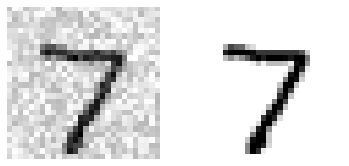

In [60]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

# 왼쪽은 잡음이 섞인 이미지, 오른쪽은 깨끗한 원본 이미지

In [61]:
# 타깃값이 원본이미지, 훈련세트는 잡음 추가한 이미지이다
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
clean_digit.shape

(1, 784)

원본 이미지와 매우 비슷하다!

## 연습문제

#### 1. MNIST 데이터셋으로 분류기를 만들어 테스트세트에서 97% 정확도 달성하기

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = KNeighborsClassifier()

In [85]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [73]:
params = [{'weights': ['uniform', 'distance'], 'n_neighbors': [3, 5, 7, 9]}]

grid_search = GridSearchCV(knn_clf, params, cv=5,    # 5-겹 교차검증 사용
                            scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': [3, 5, 7, 9],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [76]:
grid_search.best_params_

{'n_neighbors': 7, 'weights': 'distance'}

In [89]:
grid_search.best_score_

-2.91

In [77]:
grid_knn = grid_search.best_estimator_

In [79]:
scaler.transform(X_test)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [81]:
grid_knn_pred = grid_knn.predict(X_test)

In [84]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, grid_knn_pred)

0.772

In [87]:
knn_clf_pred = knn_clf.predict(X_test)
accuracy_score(y_test, knn_clf_pred)

0.815

In [88]:
accuracy_score(y_test, grid_knn_pred)

0.772